In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm
import pytensor
import seaborn as sns
import xarray as xr
from sklearn.datasets import make_moons
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

pytensor.config.cxx = "/usr/bin/clang++"


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "vectorize_roc_curve"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
x, y = make_moons(n_samples=130, noise=0.2, random_state=seed)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=seed
)

n_train = x_train.shape[0]
n_test = x_test.shape[0]
n = n_train + n_test

idx_train = range(n_train)
idx_test = range(n_train, n_train + n_test)

domain_dim = x.shape[1]

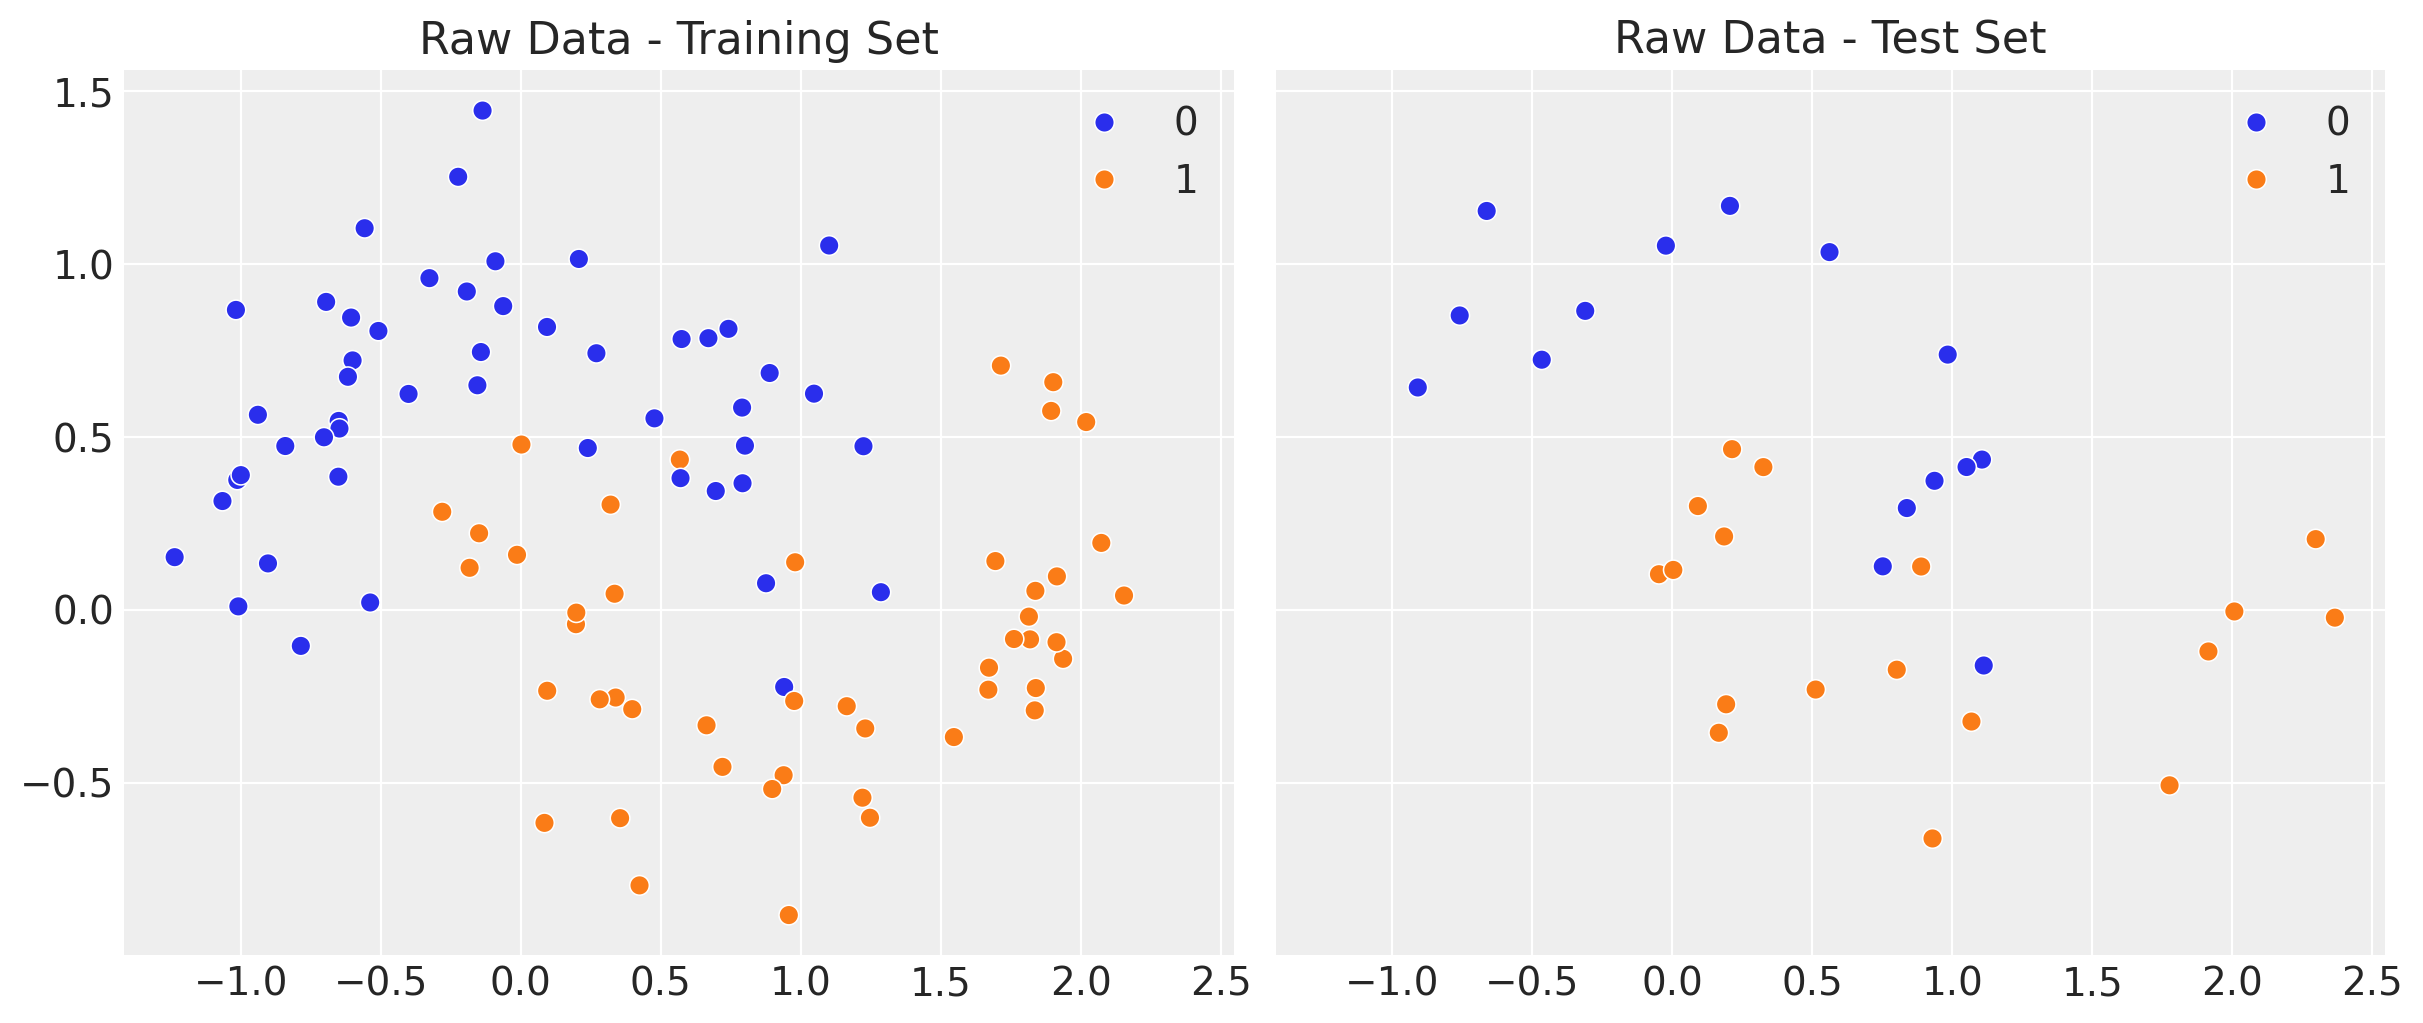

In [4]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=True,
    sharey=True,
    layout="constrained",
)
sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, ax=ax[0])
ax[0].set(title="Raw Data - Training Set")
sns.scatterplot(x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, ax=ax[1])
ax[1].set(title="Raw Data - Test Set");

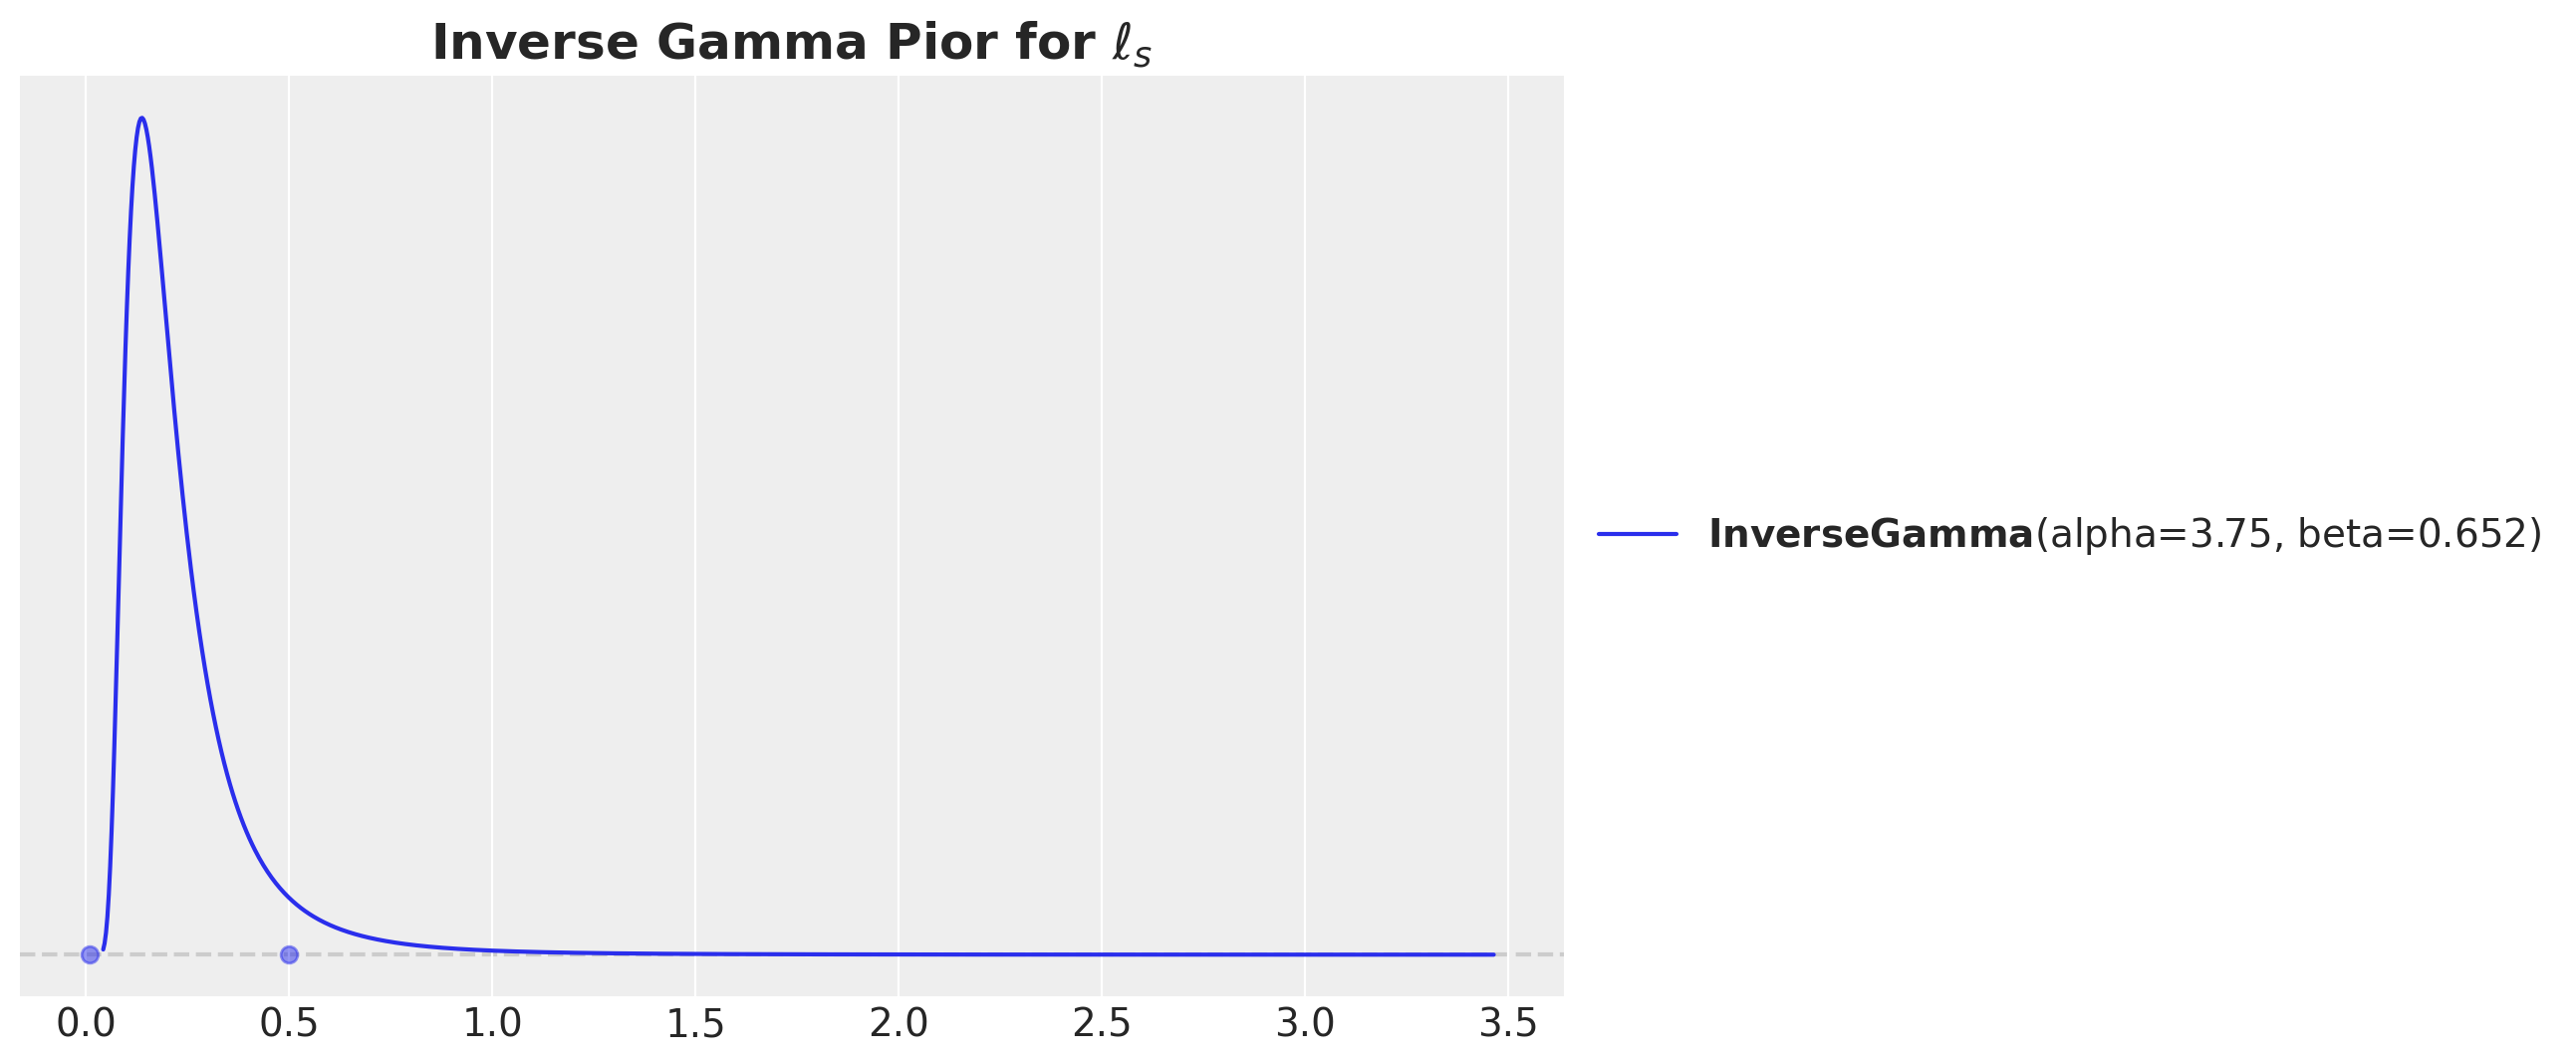

In [5]:
fig, ax = plt.subplots()

ls_params, ax = pz.maxent(pz.InverseGamma(), lower=0.01, upper=0.5, mass=0.94, ax=ax)
ax.set_title(r"Inverse Gamma Pior for $\ell_{s}$", fontsize=18, fontweight="bold");

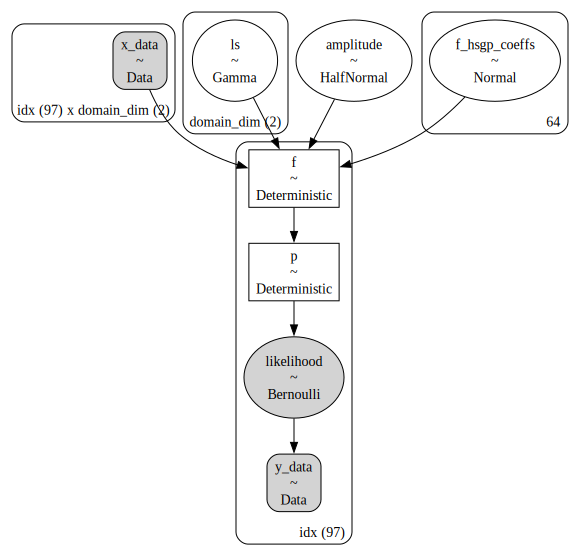

In [6]:
coords = {"domain_dim": range(domain_dim), "idx": idx_train}

with pm.Model(coords=coords) as model:
    x_data = pm.Data("x_data", x_train, dims=("idx", "domain_dim"))
    y_data = pm.Data("y_data", y_train, dims="idx")

    ls = pm.Gamma(
        name="ls", alpha=ls_params.alpha, beta=ls_params.beta, dims="domain_dim"
    )
    amplitude = pm.HalfNormal(name="amplitude", sigma=1)
    cov_func = amplitude**2 * pm.gp.cov.Matern52(input_dim=domain_dim, ls=ls)

    gp = pm.gp.HSGP(m=[8, 8], c=1.2, cov_func=cov_func)
    f = gp.prior("f", X=x_data, dims="idx")
    p = pm.Deterministic(name="p", var=pm.math.invlogit(f), dims="idx")

    pm.Bernoulli(name="likelihood", p=p, observed=y_data, dims="idx")

pm.model_to_graphviz(model)

In [7]:
with model:
    idata = pm.sample(
        draws=2_000,
        chains=4,
        nuts_sampler="nutpie",
        random_seed=rng,
    )
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.50,7
,3000,0,0.49,7
,3000,0,0.49,7
,3000,0,0.49,7


Sampling: [likelihood]


Output()

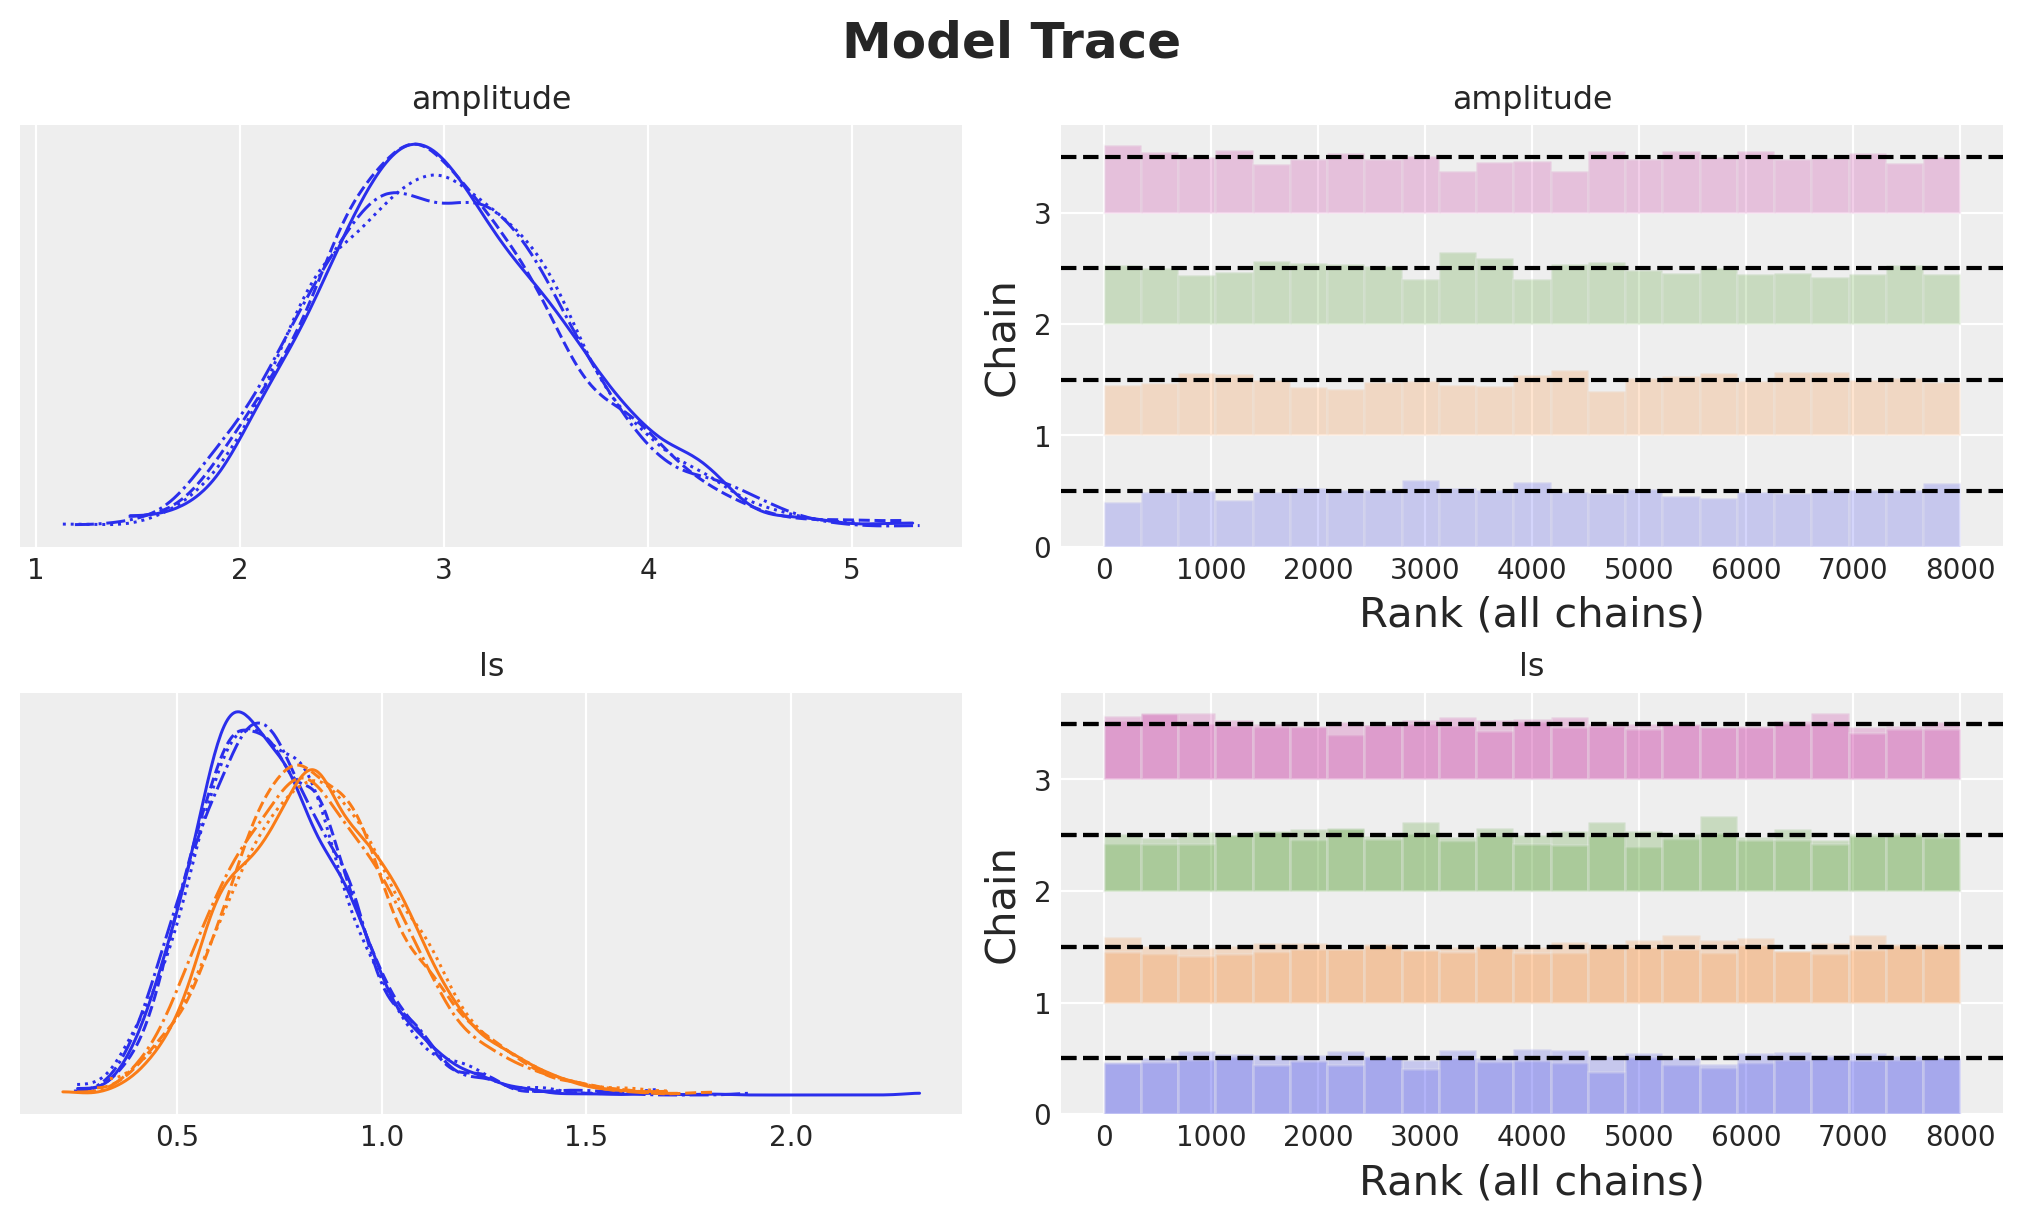

In [8]:
_ = az.plot_trace(
    data=idata,
    var_names=[
        "amplitude",
        "ls",
    ],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold");

In [9]:
with model:
    pm.set_data(
        new_data={"x_data": x_test, "y_data": np.zeros_like(y_test)},
        coords={"idx": idx_test},
    )

    idata_test = pm.sample_posterior_predictive(
        trace=idata,
        var_names=["p", "likelihood"],
        random_seed=rng,
        idata_kwargs={"coords": {"idx": idx_test}},
    )

Sampling: [likelihood]


Output()

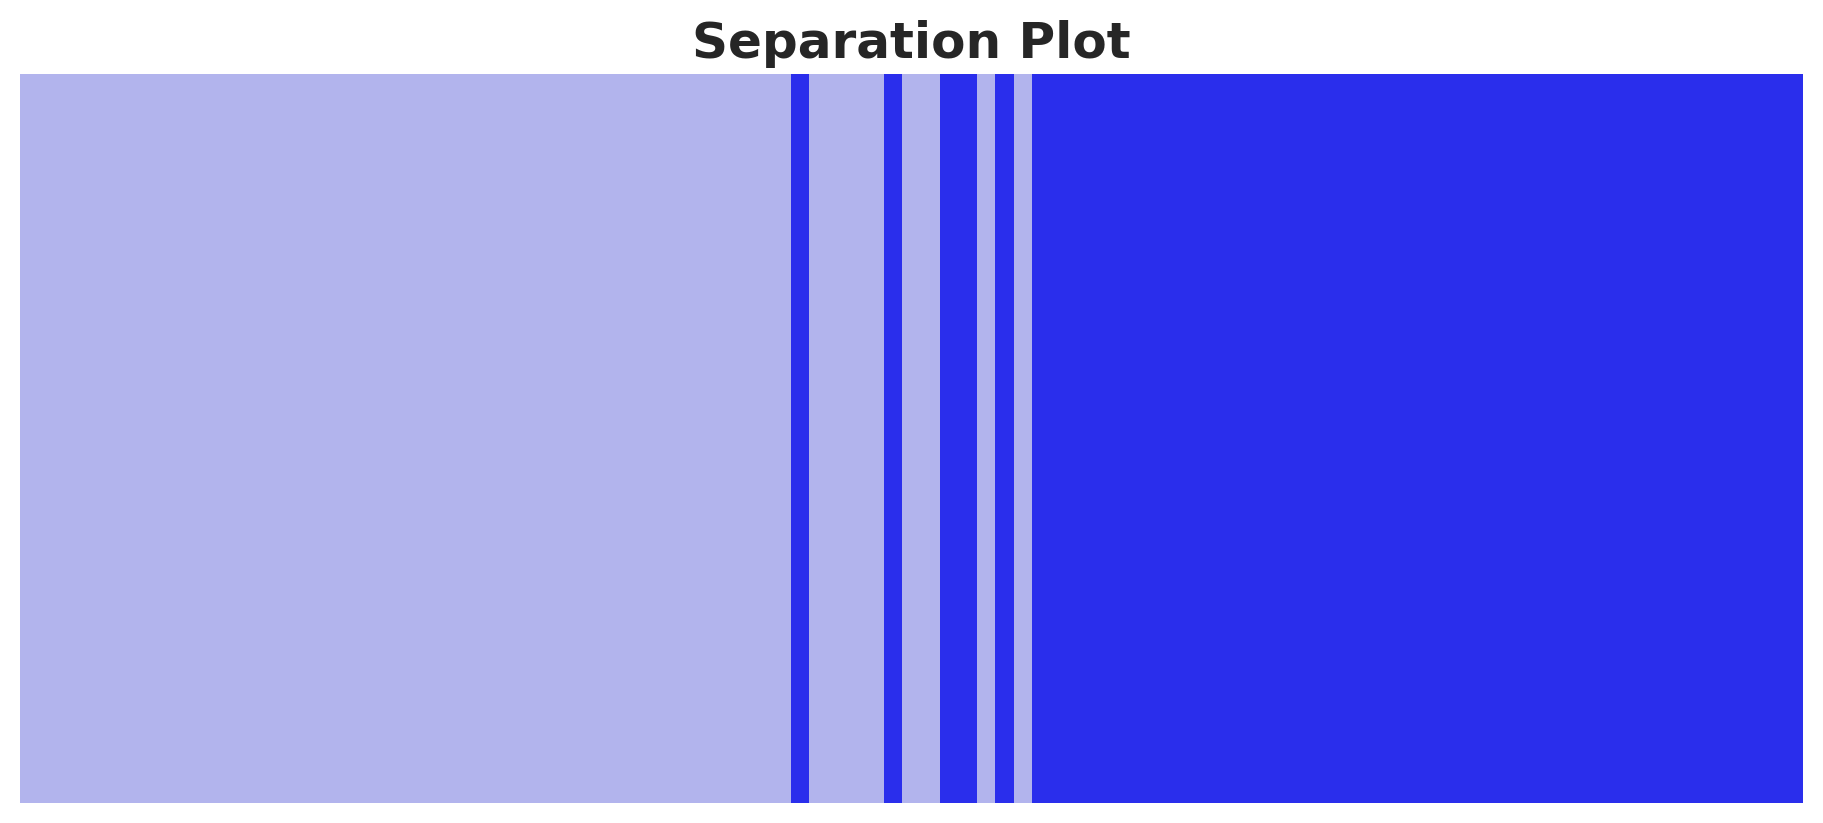

In [18]:
fig, ax = plt.subplots(figsize=(9, 4))
az.plot_separation(idata=idata, y="likelihood", ax=ax)
ax.set_title("Separation Plot", fontsize=18, fontweight="bold");

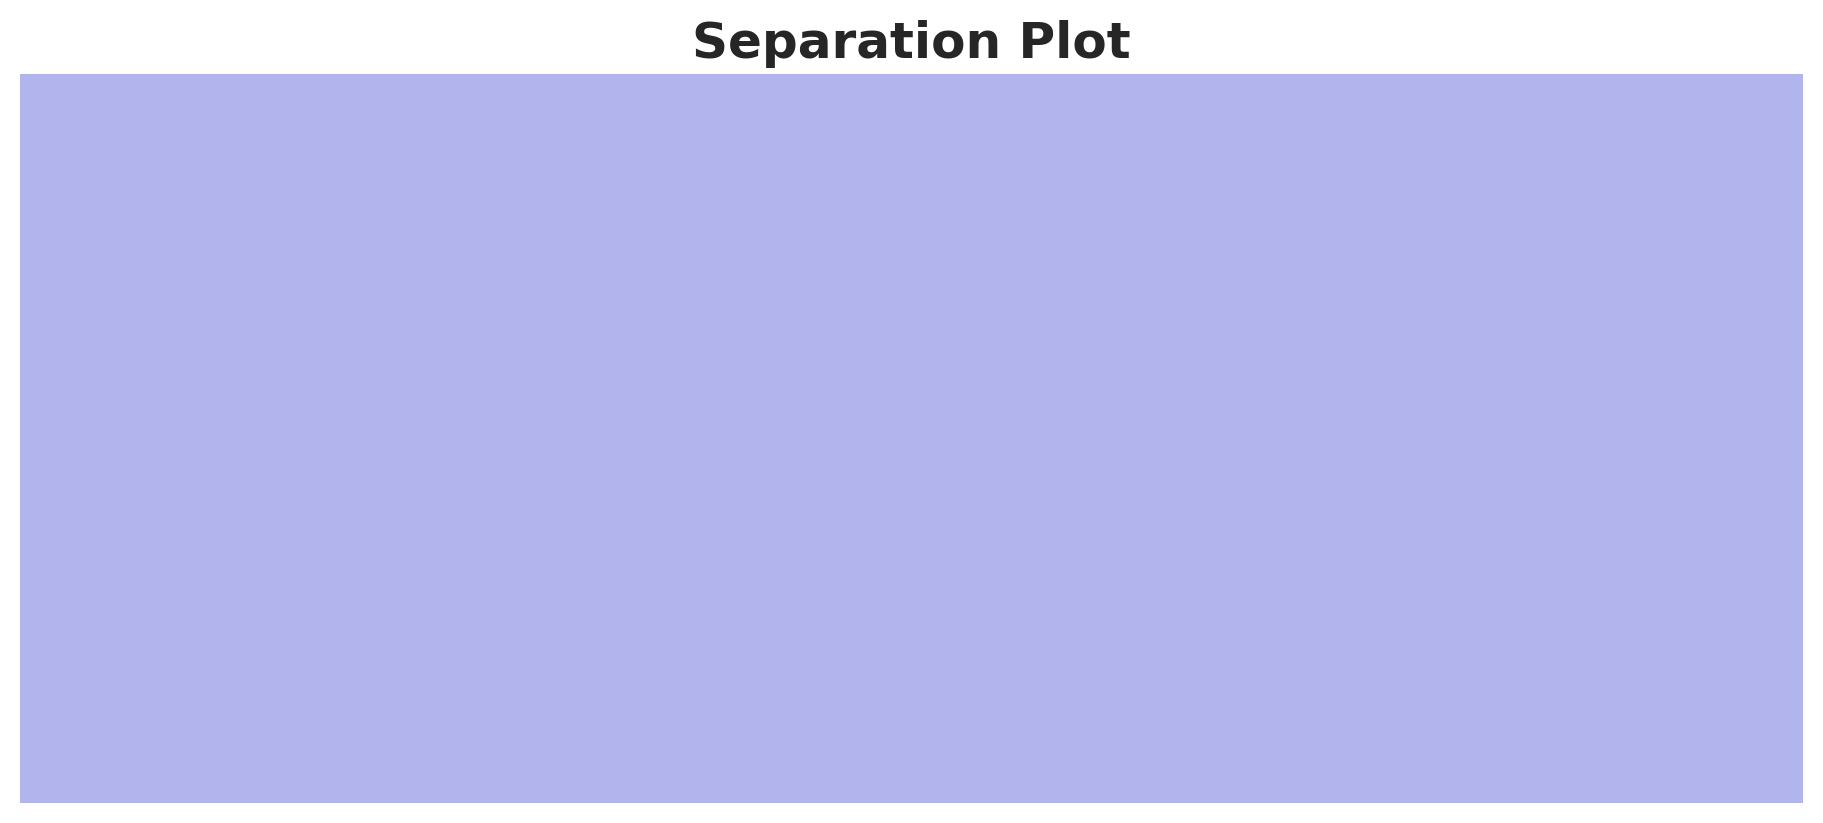

In [21]:
fig, ax = plt.subplots(figsize=(9, 4))
az.plot_separation(idata=idata_test, y="likelihood", ax=ax)
ax.set_title("Separation Plot", fontsize=18, fontweight="bold");

In [12]:
auc_train = xr.apply_ufunc(
    roc_auc_score,
    y_train,
    idata["posterior"]["p"],
    input_core_dims=[["idx"], ["idx"]],
    output_core_dims=[[]],
    vectorize=True,
)

auc_test = xr.apply_ufunc(
    roc_auc_score,
    y_test,
    idata_test["posterior_predictive"]["p"],
    input_core_dims=[["idx"], ["idx"]],
    output_core_dims=[[]],
    vectorize=True,
)

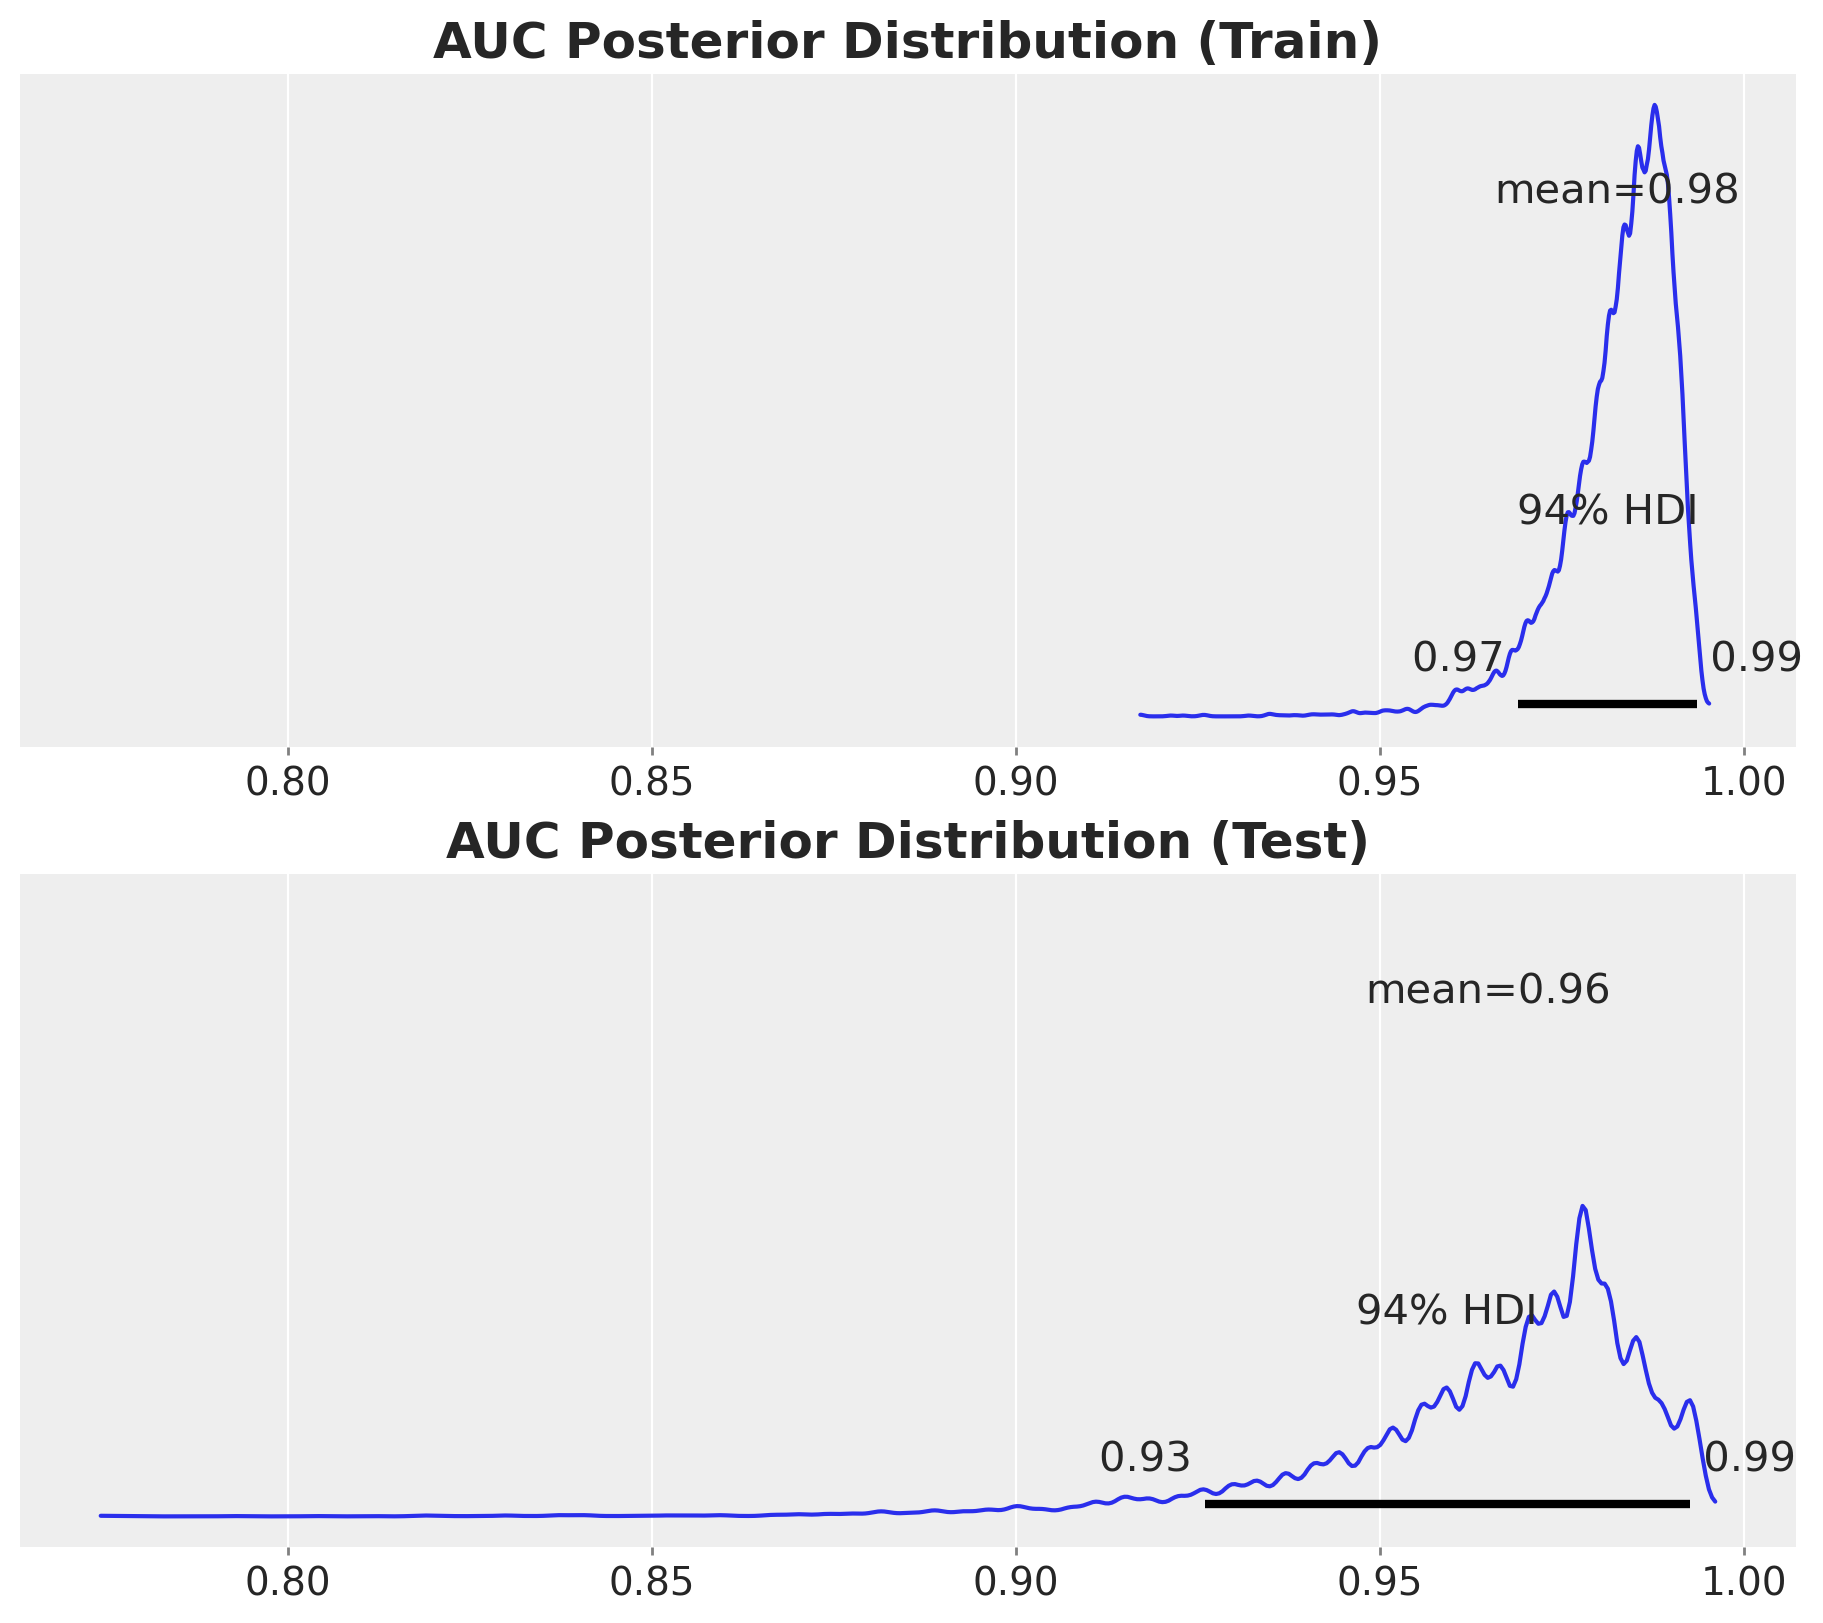

In [13]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(9, 8),
    sharex=True,
    sharey=True,
    layout="constrained",
)
az.plot_posterior(data=auc_train, ax=ax[0])
ax[0].set_title("AUC Posterior Distribution (Train)", fontsize=18, fontweight="bold")
az.plot_posterior(data=auc_test, ax=ax[1])
ax[1].set_title("AUC Posterior Distribution (Test)", fontsize=18, fontweight="bold");

In [14]:
fpr_train, tpr_train, thresholds_train = xr.apply_ufunc(
    lambda x, y: roc_curve(y_true=x, y_score=y, drop_intermediate=False),
    y_train,
    idata["posterior"]["p"],
    input_core_dims=[["idx"], ["idx"]],
    output_core_dims=[["threshld"], ["threshld"], ["threshld"]],
    vectorize=True,
)

fpr_test, tpr_test, thresholds_test = xr.apply_ufunc(
    lambda x, y: roc_curve(y_true=x, y_score=y, drop_intermediate=False),
    y_test,
    idata_test["posterior_predictive"]["p"],
    input_core_dims=[["idx"], ["idx"]],
    output_core_dims=[["threshld"], ["threshld"], ["threshld"]],
    vectorize=True,
)

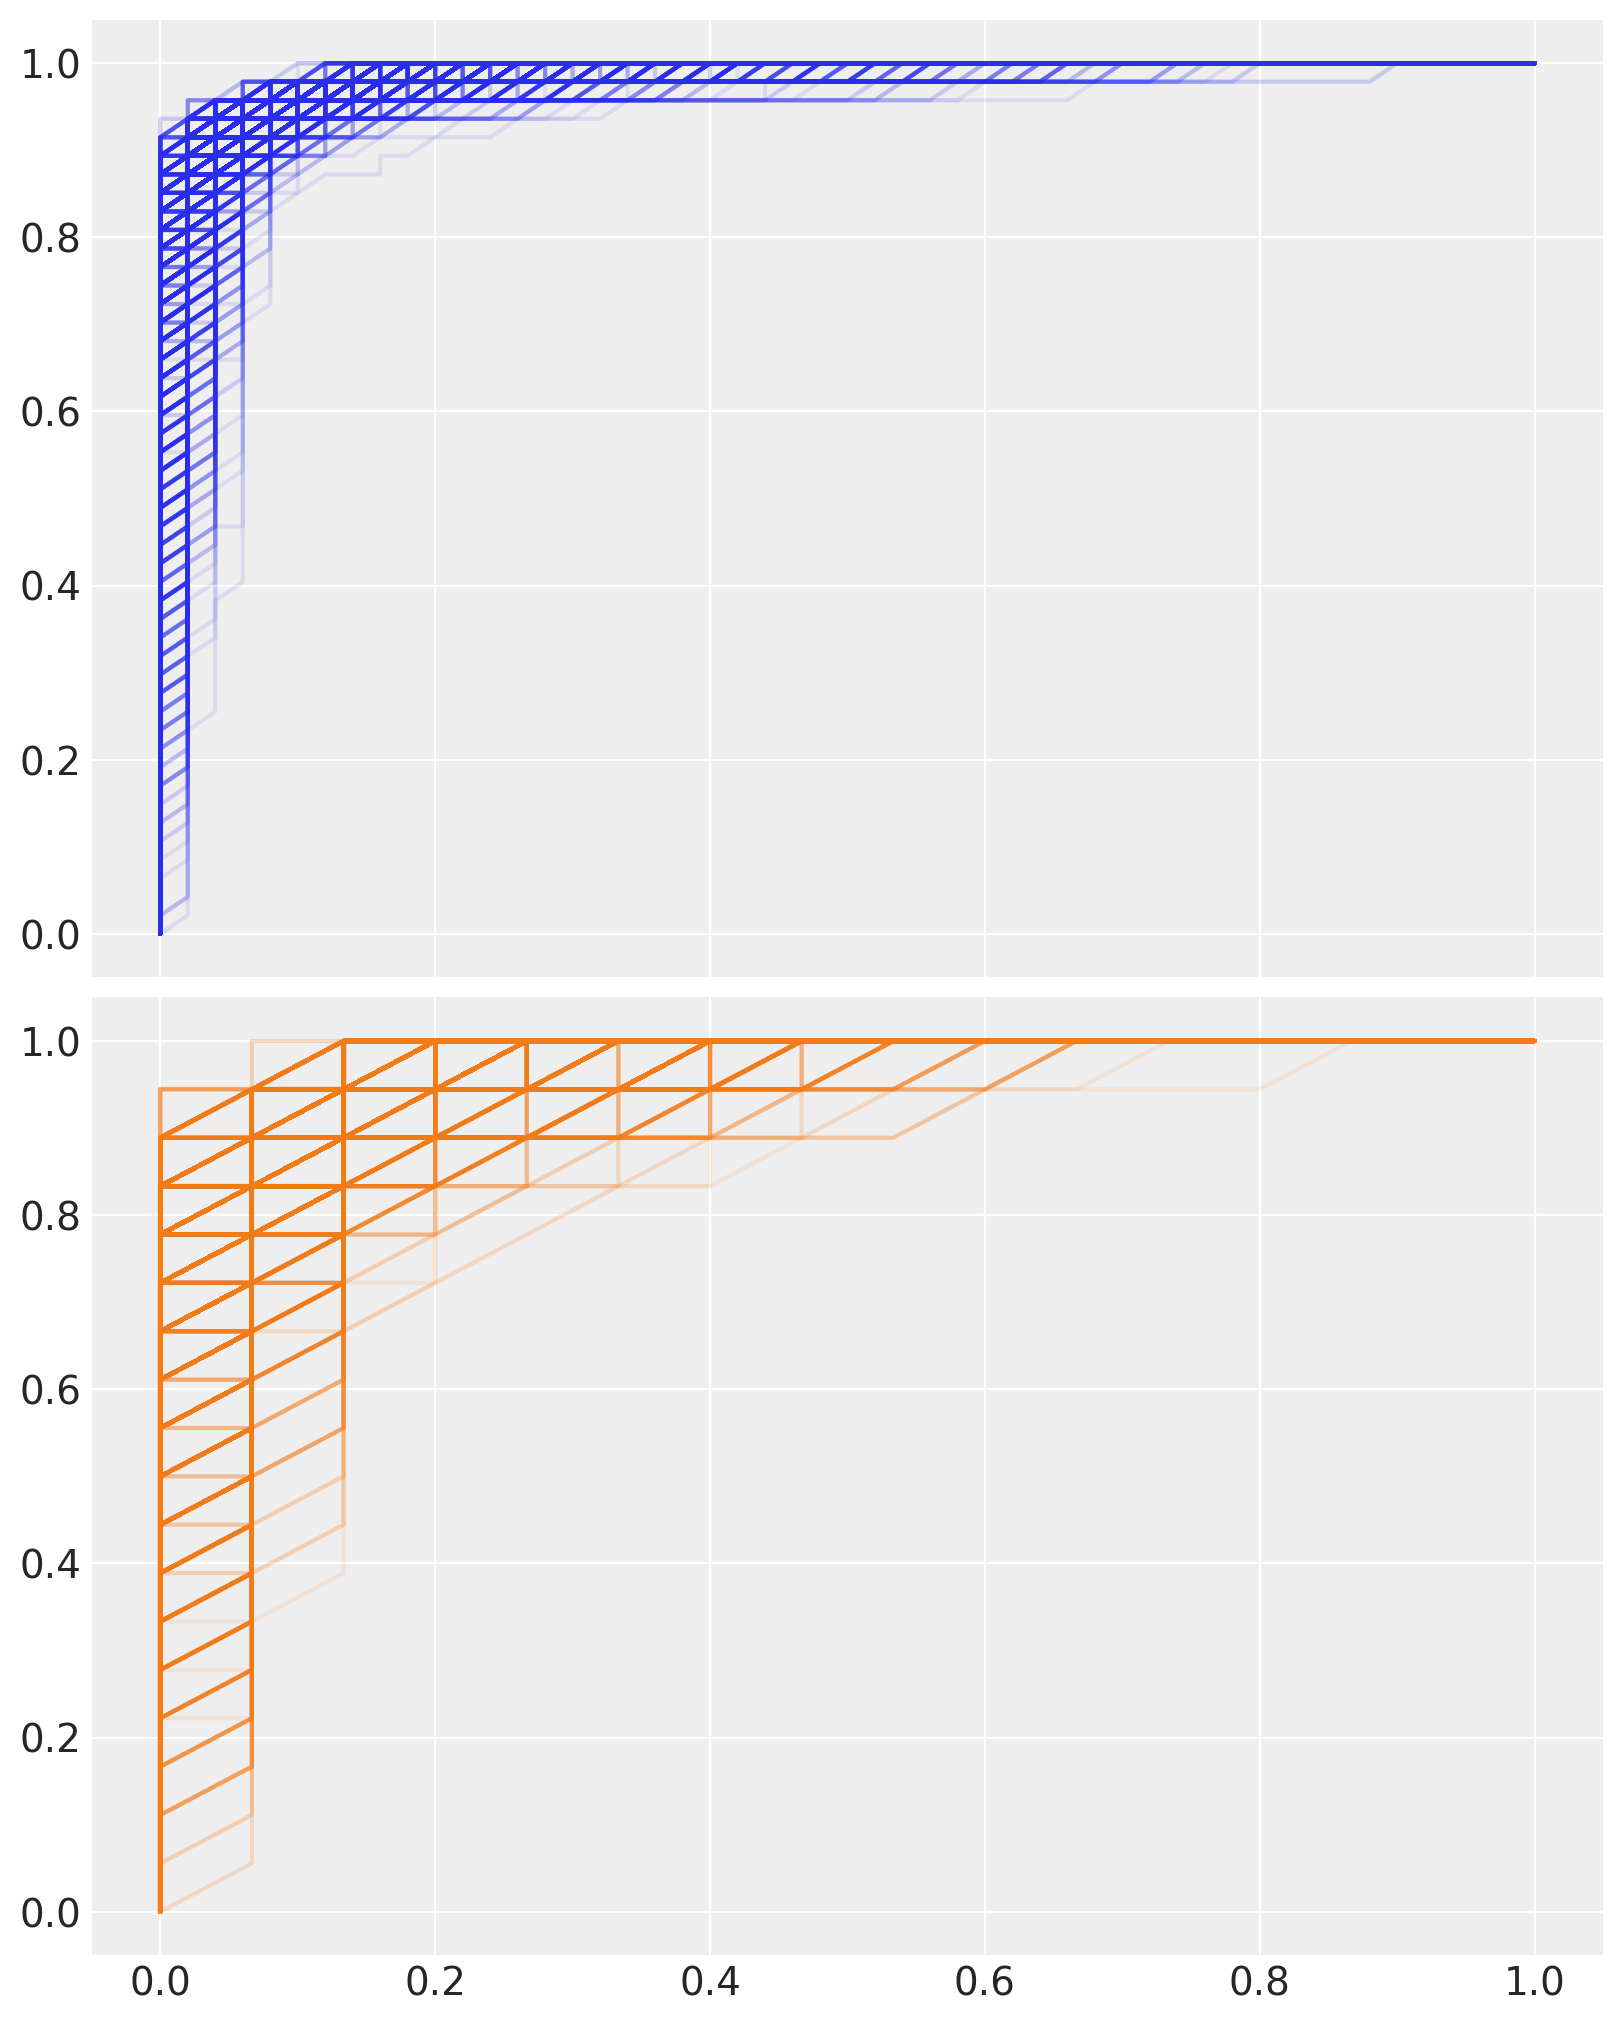

In [15]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(2_000):
    ax[0].plot(
        fpr_train.sel(chain=0, draw=i),
        tpr_train.sel(chain=2, draw=i),
        c="C0",
        alpha=0.1,
    )
    ax[1].plot(
        fpr_test.sel(chain=0, draw=i), tpr_test.sel(chain=2, draw=i), c="C1", alpha=0.1
    )

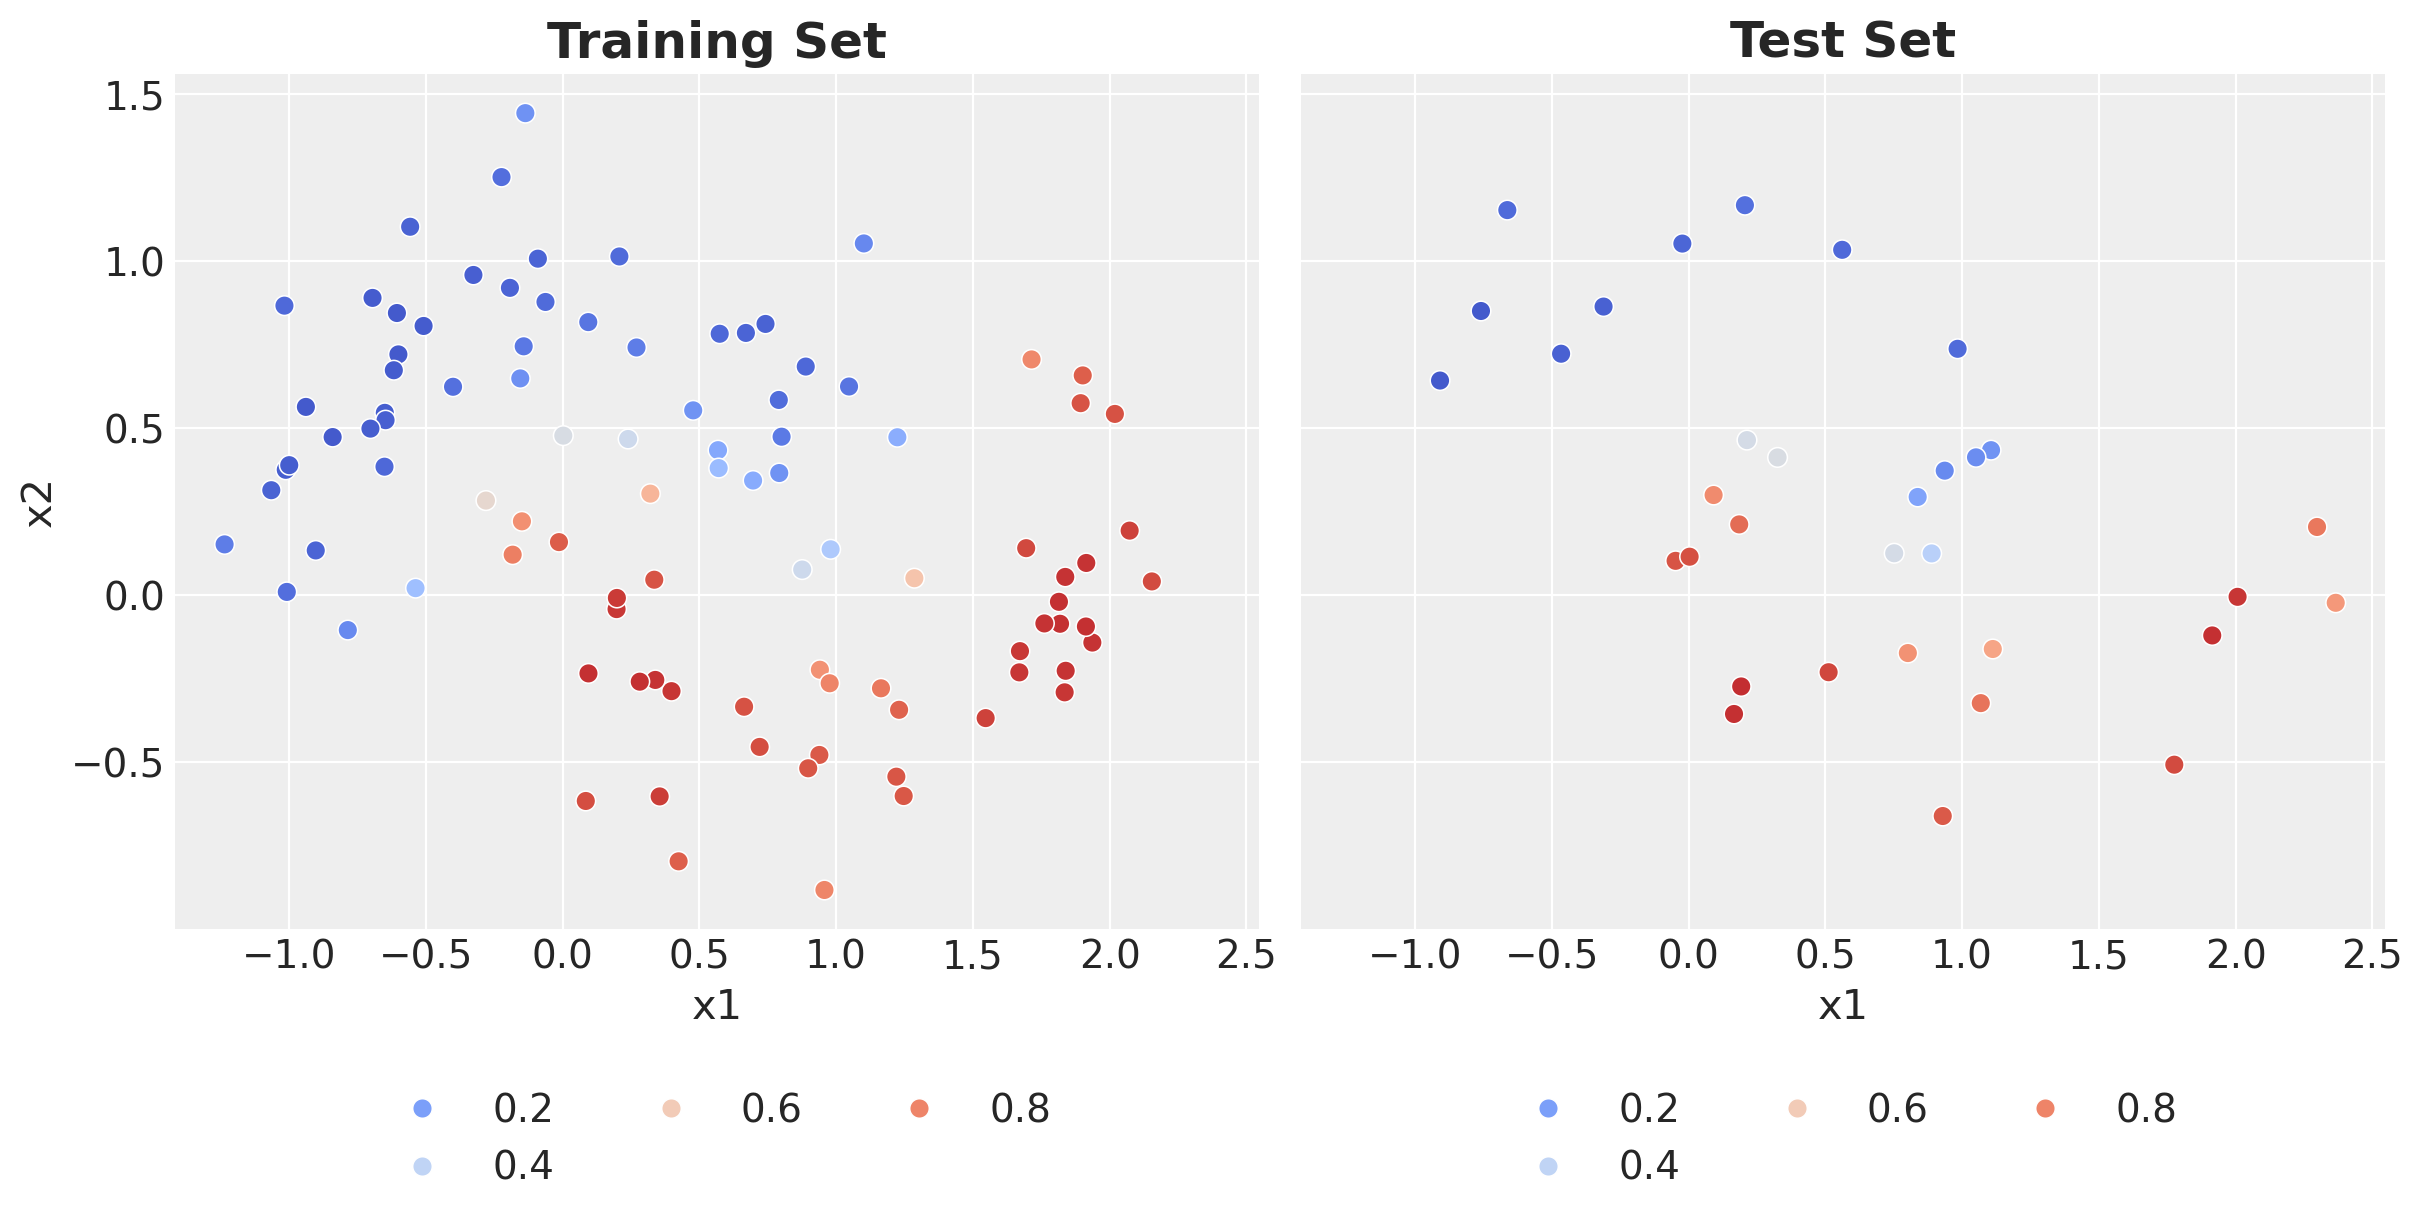

In [16]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 6),
    sharex=True,
    sharey=True,
    layout="constrained",
)

(
    idata["posterior"]["p"]
    .mean(dim=("chain", "draw"))
    .to_pandas()
    .to_frame()
    .assign(x1=x_train[:, 0], x2=x_train[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="p",
        hue_norm=(0, 1),
        palette="coolwarm",
        s=50,
        ax=ax[0],
    )
)

ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
ax[0].set_title("Training Set", fontsize=18, fontweight="bold")

(
    idata_test["posterior_predictive"]["p"]
    .mean(dim=("chain", "draw"))
    .to_pandas()
    .to_frame()
    .assign(x1=x_test[:, 0], x2=x_test[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="p",
        hue_norm=(0, 1),
        palette="coolwarm",
        s=50,
        ax=ax[1],
    )
)

ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
ax[1].set_title("Test Set", fontsize=18, fontweight="bold");